# Capstone II: Craiglist Used Car Dataset
### Part 2: Exploratory Data Analysis (EDA)

Biman Mondal\
Mar. 28, 2025

The goal of this project is to create a model to predict the price of a vehicle given the other features of the dataset as the dependent variables.\
This notebook uses the wrangled dataset from step 1 'step1_wrangled_vehicles.csv'\
Original Dataset .csv file downloaded from Kaggle:\
https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data

In [124]:
# Import numpy package
import numpy as np
# Import pandas package
import pandas as pd
# Import matplotlib package
import matplotlib.pyplot as plt
# Import the seaborn package
import seaborn as sns
# Future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [125]:
vehicles = pd.read_csv('./data/step1_wrangled_vehicles.csv', index_col=0)
vehicles.set_index('id', inplace=True)

## 1. Plot Numerical Data
#### Price Histogram and CDF
The price is the target variable in the dataset.
The price histogram shows the distribution of the prices in the dataset. \
The cumulative distribution function (CDF) is an extra visual to show where the range below most prices.

In [126]:
# Drop all prices that are null or less than 100
myind = (vehicles["price"] != 0) & (vehicles["price"] >= 100)
vehicles = vehicles[myind]

In [127]:
#print(np.isinf(vehicles['price']).sum())
pd.set_option('display.float_format', lambda x: '%.0f' % x)
vehicles['price'].describe()
# The average price of a vehicle is 19k with a standard deviation of 15k

count   297193
mean     20273
std      15011
min        500
25%       8750
50%      16995
75%      28990
max     349999
Name: price, dtype: float64

There are 0 vehicles with nan price.
There are 0 vehicles with zero price.
There are 446 vehicles with price greater than $100,000.


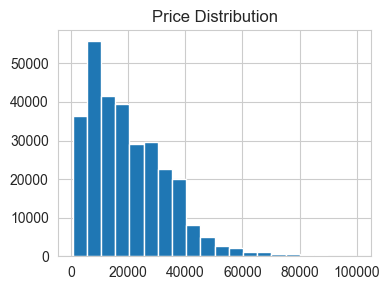

In [128]:
print(f"There are {vehicles[vehicles['price'].isna()].shape[0]} vehicles with nan price.")
print(f"There are {vehicles[vehicles['price']==0].shape[0]} vehicles with zero price.")
print(f"There are {vehicles[vehicles['price']>100000].shape[0]} vehicles with price greater than $100,000.")

myind= vehicles["price"]<100000
#print(vehicles.loc[myind,"odometer"].count())
#print(vehicles.loc[myind,"odometer"].head())
fix, ax = plt.subplots(figsize=(4,3))
plt.hist(vehicles.loc[myind,"price"],bins=20)
#ax.set_title('Vehicle Odometer')
plt.title('Price Distribution')
plt.grid(True)
plt.tight_layout()  # Ensures labels fit within the figure
plt.show()

In [129]:
# High price
high_price = vehicles.loc[vehicles["price"] > 100000,\
                          ['price','year','manufacturer','model']]
high_price.head(5)
print(f"There are {high_price.shape[0]} cars over $100k.")

There are 446 cars over $100k.


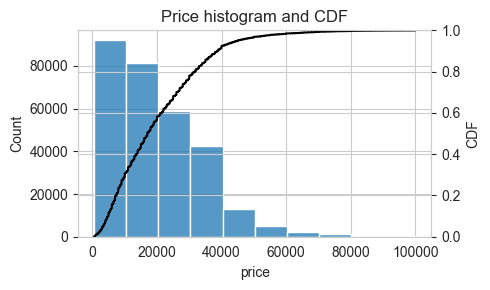

In [130]:
fig, ax1 = plt.subplots(figsize=(5,3))
#myind = vehicles['price'].notnull()
#price = vehicles.loc[myind,'price']
# Plot histogram of price
sns.histplot(vehicles.loc[vehicles['price']<=100000,'price'],bins=10,ax=ax1)
# Plot CDF on second axis
ax2=ax1.twinx()
sns.ecdfplot(vehicles.loc[vehicles['price']<=100000,'price'],color='black')
ax2.set_ylabel('CDF')
plt.grid(True)
plt.title('Price histogram and CDF')
plt.tight_layout()  # Ensures labels fit within the figure
plt.show()

#### Manufacturered Year Histograms
Most of the vehicles in the dataset are manufactured after 1980.
The distribution skews left. Use 1980 as a cutoff.

In [131]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
vehicles['year'].describe()

count   297193
mean      2012
std          9
min       1900
25%       2009
50%       2014
75%       2017
max       2022
Name: year, dtype: float64

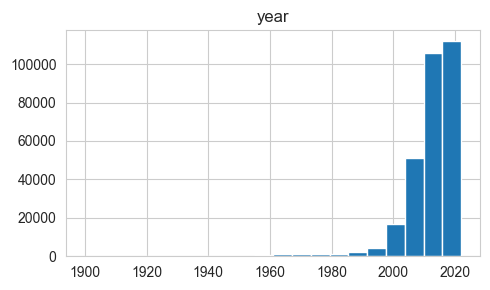

In [132]:
#fig, ax = plt.subplots(figsize=(4,3))
year = vehicles['year']
vehicles[['year']].hist(bins=20,label=['Year'],grid=True, figsize=(5,3))
plt.tight_layout()
plt.show()

There are 4453 vehicles older than 1980.


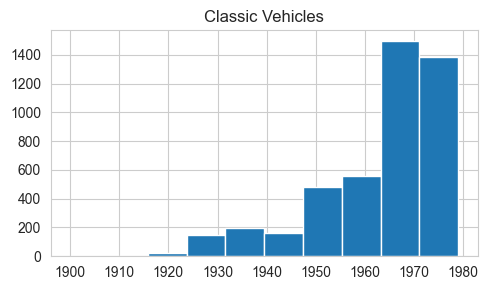

In [133]:
older_vehicle = vehicles[vehicles['year']<1980]
#print(older_vehicle[["price","year","manufacturer","model"]].head())
print(f"There are {older_vehicle.shape[0]} vehicles older than 1980.")
ax=older_vehicle[["year"]].hist(grid=True, figsize=(5,3))
plt.title('Classic Vehicles')
plt.tight_layout()
plt.show()

#### Odometer Histograms
The vehicle odometer distribution looks to be centered around 100k miles and skews right.

In [134]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
print(vehicles['odometer'].describe())
pd.reset_option('display.float_format')

count     295540
mean       91304
std       153606
min            0
25%        34439
50%        80901
75%       129746
max     10000000
Name: odometer, dtype: float64


There are 1653 vehicles with nan odometer.
There are 756 with zero miles.
There are 641 with greater than 400,000 miles.


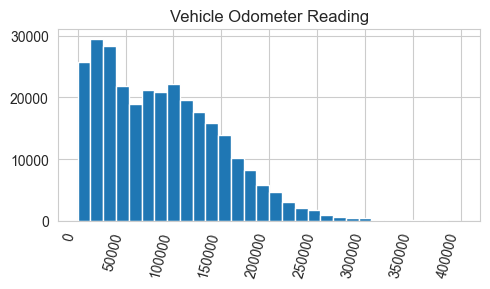

In [135]:
print(f"There are {vehicles[vehicles['odometer'].isna()].shape[0]} vehicles with nan odometer.")
print(f"There are {vehicles[vehicles['odometer']==0].shape[0]} with zero miles.")
print(f"There are {vehicles[vehicles['odometer']>400000].shape[0]} with greater than 400,000 miles.")
#print(len(vehicles["odometer"].index))
#print(vehicles["odometer"].isna().sum())
myind= (vehicles["odometer"]>0) & (vehicles["odometer"]<400000)
#print(vehicles.loc[myind,"odometer"].count())
#print(vehicles.loc[myind,"odometer"].head())
fix, ax = plt.subplots(figsize=(5,3))
plt.hist(vehicles.loc[myind,"odometer"], bins=30)
plt.grid(True)
plt.xticks(rotation=75, ha='right')
ax.set_title('Vehicle Odometer Reading')
plt.tight_layout()
plt.show()
# Drop vehicles with odometer greater than 350k
vehicles = vehicles[vehicles["odometer"]<350000]

In [136]:
# Fill in odometer reading by looking up Lcondition and year of vehicle
# Use year and condition to fill zero rows in odometer column

# [new, like new, excellent, good, fair]
# [2021-2020, 2020-2018,]
# Find 'condition' and 'year' missing

median_per_group = vehicles[vehicles['odometer']!=0].groupby(['year','condition'])['odometer'].median()

def replace_zero(row):
    if row['odometer'] == 0 or np.isnan(row['odometer']):
        condition = row['condition'] if pd.notna(row['condition']) else 'good'
        key = (row['year'], condition)
        if key in median_per_group:
            return median_per_group[key]
        elif row['year'] :
            return 0
    else: 
        return row['odometer']
vehicles['odometer'] = vehicles.apply(replace_zero, axis=1)

print(f"There are {vehicles[vehicles['odometer'].isna()].shape[0]} rows with nan odometer.")
print(f"There are {vehicles[vehicles['odometer']==0].shape[0]} rows with zero odometer.")

There are 0 rows with nan odometer.
There are 0 rows with zero odometer.


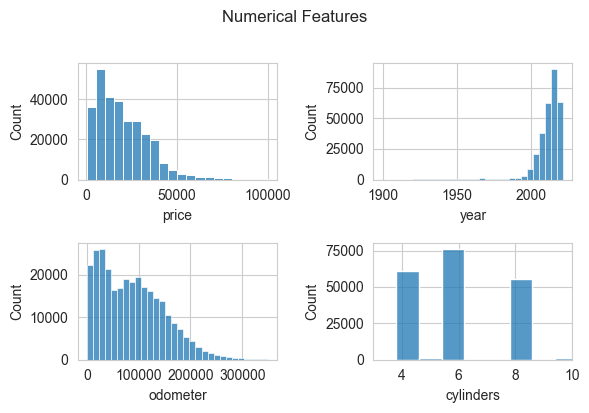

In [137]:
# Make subplots
fig, axes = plt.subplots(2,2, figsize=(6, 4))

#Plot 
sns.histplot(vehicles.loc[vehicles["price"]<100000,"price"],bins=20,ax=axes[0,0])

# Plot Year
sns.histplot(vehicles['year'],bins=30, ax=axes[0,1])

# Plot odometer
sns.histplot(vehicles.loc[(vehicles["odometer"]>0) & (vehicles["odometer"]<400000),"odometer"],bins=30, ax=axes[1,0])

# Plot Cylinders
foo = vehicles['cylinders'].str.replace(' cylinders','').dropna()
foo = foo[foo!='other'].astype('int')
sns.histplot(foo,ax=axes[1,1],binwidth=0.8)
plt.xlim(3, 10) 

plt.suptitle('Numerical Features', y=1.02)
plt.tight_layout()
plt.show()

## 2. Categorical Plots

#### Top 10 Manufacturers

In [1]:
vehicles['manufacturer'].value_counts()

NameError: name 'vehicles' is not defined

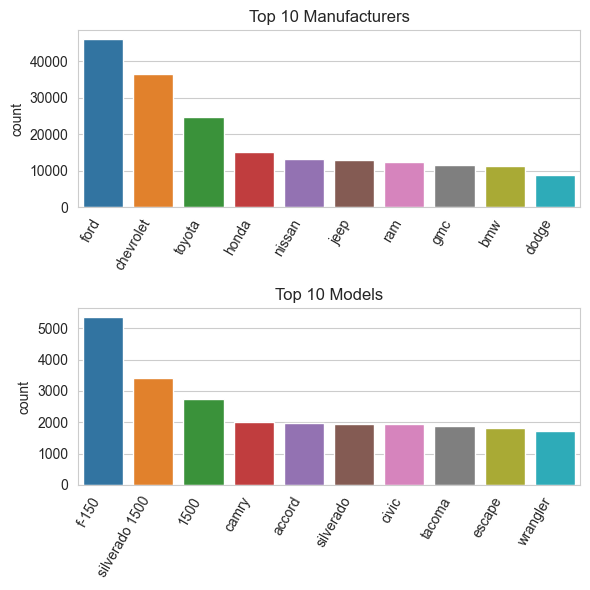

In [138]:
# Make subplots
fig, axes = plt.subplots(2,1, figsize=(6, 6))

# Plotting the percentage distribution of a single categorical variable
top10_manf_ind = vehicles['manufacturer'].value_counts().nlargest(10).index
# Filter the DataFrame to include only the top 10 categories
top10_manf = vehicles[vehicles['manufacturer'].isin(top10_manf_ind)]
# Plot
ax1 = sns.countplot(data=top10_manf, x='manufacturer',order=top10_manf_ind,ax=axes[0])
labels1 = ax1.get_xticklabels()
ax1.set_xticklabels(labels1, rotation=60, ha='right')
ax1.set_title("Top 10 Manufacturers")
ax1.set_xlabel("")

top_models_indices = vehicles['model'].value_counts().nlargest(10).index
top10_models = vehicles[vehicles['model'].isin(top_models_indices)]

ax2 = sns.countplot(data=top10_models, x='model',order=top_models_indices,ax=axes[1])
labels1 = ax2.get_xticklabels()
ax2.set_xticklabels(labels1, rotation=60, ha='right')
ax2.set_title("Top 10 Models")
ax2.set_xlabel("")

plt.tight_layout()
plt.show()

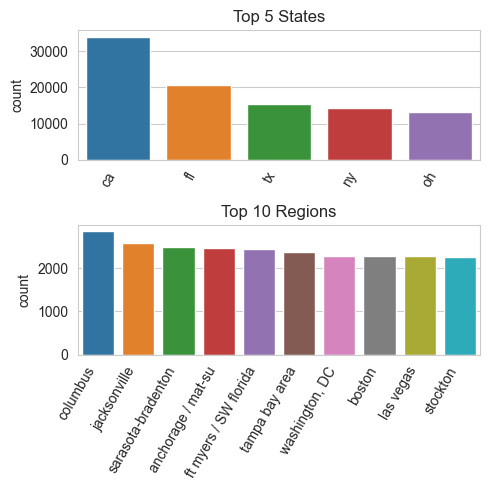

In [139]:
# Make subplots
fig, axes = plt.subplots(2,1, figsize=(5, 5))

# Plotting the percentage distribution of a single categorical variable
top5_state_ind = vehicles['state'].value_counts().nlargest(5).index
# Filter the DataFrame to include only the top 10 categories
top5_state = vehicles[vehicles['state'].isin(top5_state_ind)]
ax = sns.countplot(data=top5_state, x='state',order=top5_state_ind,ax=axes[0])
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=60, ha='right')
ax.set_title("Top 5 States")
ax.set_xlabel("")

# Plotting the percentage distribution of a single categorical variable
top10_reg_ind = vehicles['region'].value_counts().nlargest(10).index
# Filter the DataFrame to include only the top 10 categories
top10_reg = vehicles[vehicles['region'].isin(top10_reg_ind)]
ax = sns.countplot(data=top10_reg, x='region',order=top10_reg_ind,ax=axes[1])
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=60, ha='right')
ax.set_title("Top 10 Regions")
ax.set_xlabel("")

#
plt.tight_layout()
plt.show()

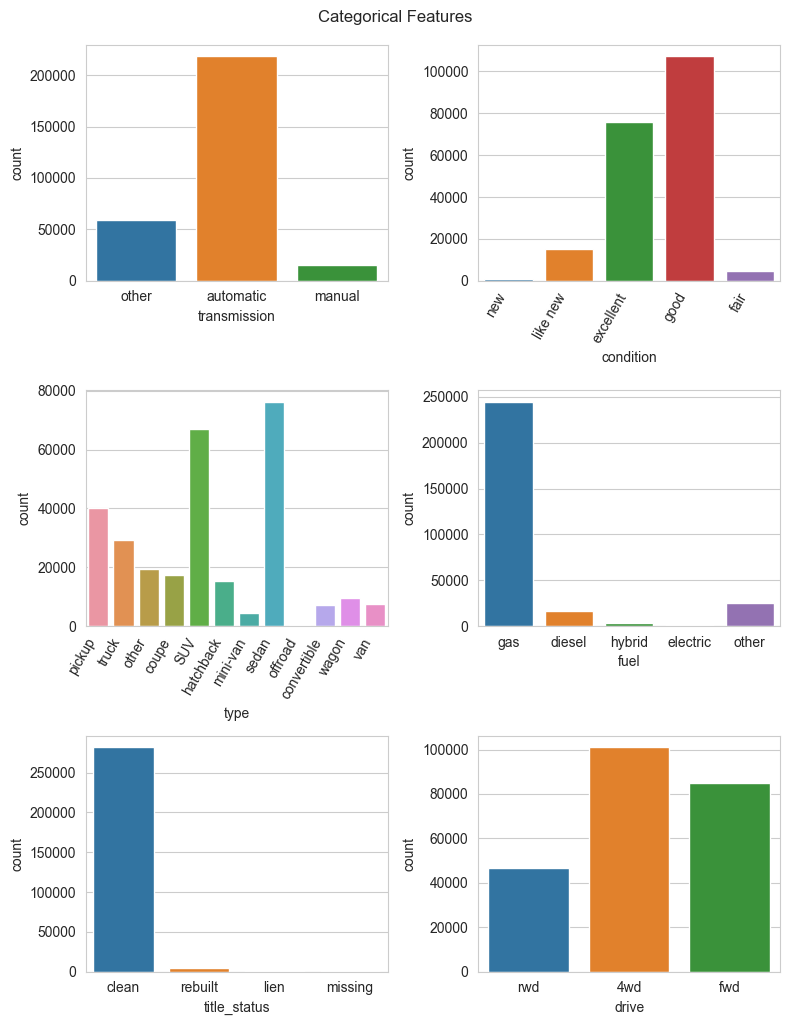

In [140]:
# Make subplots
fig, axes = plt.subplots(3,2, figsize=(8, 10))

# Plot Transmission
sns.countplot(data=vehicles, x='transmission', ax=axes[0,0])

# Plot Condition
cond_order = ["new","like new","excellent","good","fair"]
sns.countplot(x="condition",data=vehicles,order=cond_order,ax=axes[0,1])
labels = axes[0,1].get_xticklabels()
axes[0,1].set_xticklabels(labels, rotation=60, ha='right')

# Plot Vehicle Type
sns.countplot(x="type",data=vehicles,ax=axes[1,0])
labels = axes[1,0].get_xticklabels()
axes[1,0].set_xticklabels(labels, rotation=60, ha='right')

# Plot Vehice Fuel
sns.set_style("whitegrid")
fuel_order = ["gas","diesel","hybrid","electric","other"]
g=sns.countplot(x="fuel",data=vehicles,order=fuel_order,ax=axes[1,1])

# Plot Title Status
sns.countplot(x="title_status",data=vehicles,ax=axes[2,0])

# Plot Vehicle Drive
sns.countplot(x="drive",data=vehicles,ax=axes[2,1])

# Plot Cylinders
#cylin_order = ['3','4','5','6','8','10','12','other']
#sns.countplot(x="cylinders",data=vehicles,ax=axes[3,0])

# Plot Paint Color
#sns.countplot(x="paint_color",data=vehicles,ax=axes[3,1])
#labels = axes[3,1].get_xticklabels()
#axes[3,1].set_xticklabels(labels, rotation=60, ha='right')

plt.tight_layout()
plt.suptitle('Categorical Features', y=1.02)
plt.show()

From the categorical plots above shows that the dataset has mostly automatic vehicles that are gas powered with clean titles. There are more 4wd than front wheel drive vehicles which is surprising. Additionally most of the vehicles are in excellent condition.

#### Plot relationship between Price, Mileage, and Year

In [141]:
top_vehicles = vehicles['manufacturer'].value_counts()
top_10_price = vehicles.loc[vehicles['manufacturer'].isin(top_vehicles[:9].index),['manufacturer','price']]

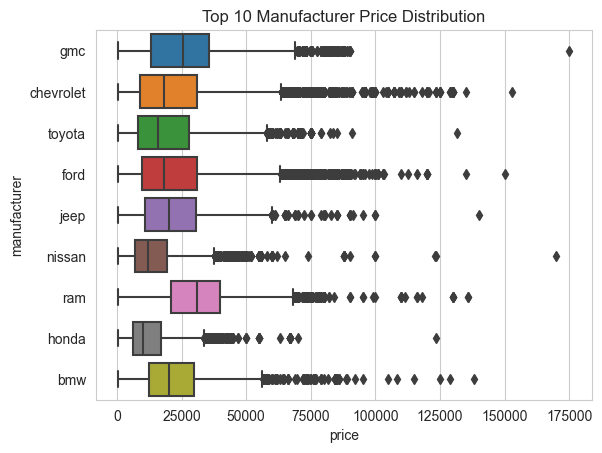

In [142]:
g=sns.boxplot(x=top_10_price['price'],
              y=top_10_price['manufacturer'])
#plt.xticks(rotation=65)
plt.title('Top 10 Manufacturer Price Distribution')
plt.show()

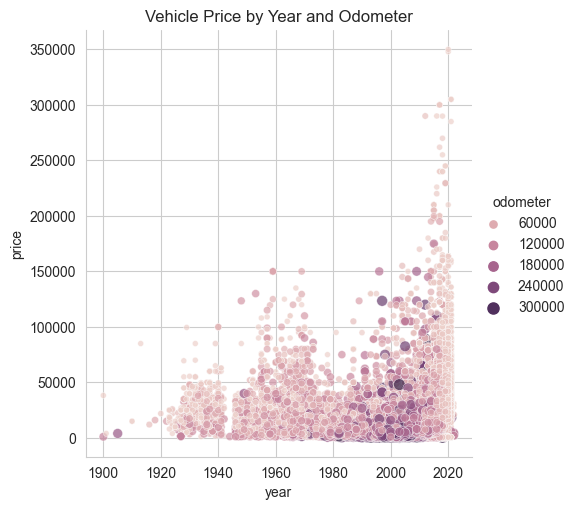

In [143]:
# There's no real trend between odometer reading and age of vehicles
# Most of the high mileage vehicles are between 2000 and 2020
sns.relplot(x='year',
           y='price',
           data=vehicles,
           kind='scatter',
           hue = 'odometer',
           size='odometer',
           alpha=0.7)
plt.title('Vehicle Price by Year and Odometer')
plt.show()

## 3. Tidy Categorical Columns

In [144]:
print(vehicles['cylinders'].unique())
# Drop "cylinders" to plot vehicle engine size
vehicles['cylinders'] = vehicles['cylinders'].str.replace(' cylinders', '', regex=False)
print(vehicles['cylinders'].unique())

['8 cylinders' '6 cylinders' nan '4 cylinders' '5 cylinders' '3 cylinders'
 '10 cylinders' '12 cylinders' 'other']
['8' '6' nan '4' '5' '3' '10' '12' 'other']


In [145]:
# Convert data to number
vehicles['cylinders'] = pd.to_numeric(vehicles['cylinders'], errors='coerce')

# Replace NAN's to median
vehicles['cylinders'] = vehicles['cylinders'].fillna(vehicles['cylinders'].median())
print(vehicles['cylinders'].unique())

[ 8.  6.  4.  5.  3. 10. 12.]


In [146]:
print(vehicles['type'].unique())
#myind = vehicles['type']=="other"
#vehicles.loc[myind,["price","type","manufacturer","model"]]

['pickup' 'truck' 'other' 'coupe' 'SUV' 'hatchback' 'mini-van' 'sedan'
 'offroad' 'convertible' 'wagon' 'van']


In [147]:
# Combine mini-van and van to van and truck and pickup to pickup
vehicles.loc[vehicles['type']=='mini-van','type'] = 'van'
vehicles.loc[vehicles['type']=='truck','type'] = 'pickup'

print(vehicles['type'].unique())

['pickup' 'other' 'coupe' 'SUV' 'hatchback' 'van' 'sedan' 'offroad'
 'convertible' 'wagon']


In [148]:
# Most of the vehicle fuels are gasoline engines
# Assume fuel NA rows are gas, 
print('Before:',vehicles['fuel'].unique())
vehicles['fuel'] = vehicles['fuel'].fillna('gas')
print(vehicles['fuel'].unique())

Before: ['gas' 'other' 'diesel' 'hybrid' nan 'electric']
['gas' 'other' 'diesel' 'hybrid' 'electric']


In [149]:
# Drop vehicles with title with 'parts only' or 'salvage'
print('Before:', vehicles['title_status'].unique())
myfilt = ((vehicles['title_status'].isin(["salvage"])) | (vehicles['title_status'].isin(['parts only'])))
vehicles = vehicles.loc[~myfilt,:]
print('After:',vehicles['title_status'].unique())


Before: ['clean' 'rebuilt' 'lien' nan 'missing']
After: ['clean' 'rebuilt' 'lien' nan 'missing']


In [150]:
# Drop Salvage in condition
vehicles = vehicles[~vehicles['condition'].isin(['salvage'])]
print(f"There are {vehicles['condition'].isna().sum()} Nan's.")
print('Before:',vehicles['condition'].unique())

# Replace NaN's with 'good'
vehicles['condition'] = vehicles['condition'].fillna('good')
print('After:',[vehicles['condition'].unique()])

There are 91051 Nan's.
Before: ['good' 'excellent' 'fair' 'like new' 'new' nan]
After: [array(['good', 'excellent', 'fair', 'like new', 'new'], dtype=object)]


In [151]:
vehicles['drive'] = vehicles['drive'].fillna('fwd')

In [152]:
# Get the data information
vehicles.info()
rows_cols = vehicles.shape

<class 'pandas.core.frame.DataFrame'>
Index: 294684 entries, 7316814884 to 7301591129
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   url           294684 non-null  object 
 1   region        294684 non-null  object 
 2   region_url    294684 non-null  object 
 3   price         294684 non-null  int64  
 4   year          294684 non-null  int64  
 5   manufacturer  285893 non-null  object 
 6   model         292314 non-null  object 
 7   condition     294684 non-null  object 
 8   cylinders     294684 non-null  float64
 9   fuel          294684 non-null  object 
 10  odometer      294684 non-null  float64
 11  title_status  288621 non-null  object 
 12  transmission  293252 non-null  object 
 13  VIN           208779 non-null  object 
 14  drive         294684 non-null  object 
 15  size          102124 non-null  object 
 16  type          294684 non-null  object 
 17  paint_color   242742 non-null  object 
 

In [153]:
# Convert categorical columns to Numerical

#columns_to_factorize = ['region','manufacturer', 'model','condition','fuel','title_status','transmission','drive','type']
#fact_col_name=[col + '_code' for col in columns_to_factorize]

#for col, col_new in zip(columns_to_factorize,fact_col_name):
 #   vehicles[col_new], _ = pd.factorize(vehicles[col])

### Correlation Heatmap

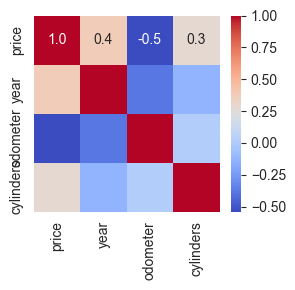

In [161]:
# Make a heatmap of the data 
num_cols = ["price","year","odometer","cylinders"]
plt.figure(figsize=(3, 3))
sns.heatmap(vehicles[num_cols].corr(), annot=True, fmt=".1f", cmap='coolwarm')
plt.tight_layout()
plt.show()

There is a clear inverse correlation between mileage and year with price. However, the factorized columns don't seem to show any real relationship to price. 

## 4. Drop Unnecessary Columns

After a back and forth between between data wrangling and this EDA step, conclusion to drop columns deemed to be unnecessary. The county field is completely, although it can be populated, it does not seem to be an important feature. The description of the vehicles could be used to extract more information but would also require use of NLP techniques. The URL, VIN, and image columns also won't provide useful information in order to predict price.

In [162]:
vehicles.columns

Index(['url', 'region', 'region_url', 'price', 'year', 'manufacturer', 'model',
       'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

In [196]:
# Drop URL, region_url, VIN, image_url, description
# Drop URL's because they won't be used
# Drop VIN because it does not affect price
# Drop paint_color because most of the rows are missing

cols_to_drop = ['url','region','region_url','VIN','size','paint_color','image_url',\
               'description','county','state','lat','long','posting_date',]
for col in cols_to_drop:
    if vehicles.columns.isin([col]).any():
        vehicles = vehicles.drop(col, axis=1)

              missing_count
price                     0
year                      0
manufacturer           8791
model                  2370
condition                 0
cylinders                 0
fuel                      0
odometer                  0
title_status           6063
transmission           1432
drive                     0
type                      0


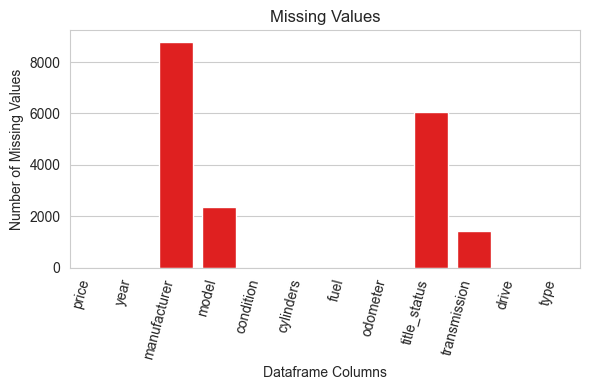

In [198]:
# Plot the data
myfilter = pd.DataFrame(vehicles.isnull().sum(),columns=['missing_count'])
print(myfilter)

# Calculate the number of missing values in each column
myfilter = pd.DataFrame(vehicles.isnull().sum(), columns=['missing_count'])

# Create a bar plot using seaborn
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
sns.barplot(x=myfilter.index, y='missing_count', data=myfilter, color='red')

# Rotate x-axis labels and align them properly
plt.xticks(rotation=75, ha='right')

# Add labels and title
plt.title('Missing Values')
plt.xlabel('Dataframe Columns')
plt.ylabel('Number of Missing Values')

# Improve layout and display the plot
plt.tight_layout()  # Ensures labels fit within the figure
plt.show()

In [200]:
# Write the subset of the data to .csv file
#vehicles.head()
vehicles.to_csv('./data/step2_vehicles_eda.csv')

## Summary

The columns not likely to be useful in predicting price have been dropped from the dataframe (image_url). The null and nan values have been removed as much as possible where necessary. In the mileage (odometer) column, the year and condition were used to provide the replace the null/nan values with the median.

Price, odometer, year, and cylinders (engine size) are the only numeric features in the dataset. The others are categorical and need to be modified using pd.factorize(). There are many rows of model section that is mistyped or mislabeled. 

The histograms show that the price skews right and has a median around 10k. There are very few vehicles above 100k. 
The histogram of the mileage shows that the there is a peak around 100k miles and skews right as well. There are very few vehicles above 150k miles. The manufactured year skews left with the median around 2011.  

Plotting the scatter of the price, the newer vehicles tend to be lower mileage and higher price. But there's no visual correlation. The sample regression analysis shows poor prediction of price with the chosen variables. Further work will be performed in the next section to improve the prediction. 
